In [1]:
%%capture --no-stdout
%reload_ext watermark
%watermark -uniz --author "Prayson W. Daniel" -vm -p pandas,numpy,dagster,scikit-learn,plotly,darts

Author: Prayson W. Daniel

Last updated: 2022-06-23T14:52:37.166840+02:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pandas      : 1.4.2
numpy       : 1.22.4
dagster     : 0.14.20
scikit-learn: 1.1.1
plotly      : 5.8.2
darts       : 0.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.10.102.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



# Toying with Data

In [2]:
import warnings
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
# from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
from darts.metrics import rmse, mae
import plotly.express as px


warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

### DATA
> Data type checker for Alm.Salg and year greater than 2016

```sql
SELECT price, solddate FROM boliga_sold
WHERE saletype = 'Alm. Salg' 
    AND DATE_PART('year', solddate::date) > 2016
```


In [18]:
%%time

FREQ = "2W"
dataf = (
            pd
             .read_csv("data/boliga-1655125832696.csv", parse_dates=["solddate"], index_col="solddate")
             .sort_values(by='solddate')
             .resample(rule=FREQ ) # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
             .mean()
            .reset_index()
        )

CPU times: user 186 ms, sys: 0 ns, total: 186 ms
Wall time: 186 ms


In [19]:
dataf.tail(3)

,solddate,price
296,2022-05-15,3042600.0
297,2022-05-29,5647500.0
298,2022-06-12,4795000.0


In [20]:
plot_params = dict(backend="plotly",
                title=f'{FREQ} Sum Prices Over Time',
                labels=dict(index="Time Line", 
                            value="DKK", 
                            variable="Agg Price DKK",
                            solddate="Sold Date")
                  )

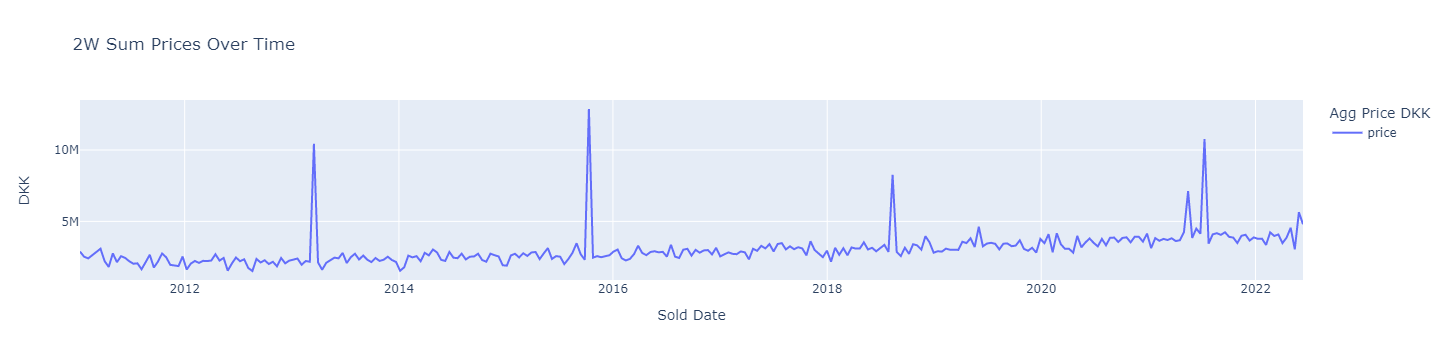

In [21]:
dataf.set_index('solddate').plot(**plot_params)

In [22]:
(
    dataf
        .loc[lambda d: d["price"].between(d["price"].quantile(.25), d["price"].quantile(.75))]
        .shape
    
)

(149, 2)

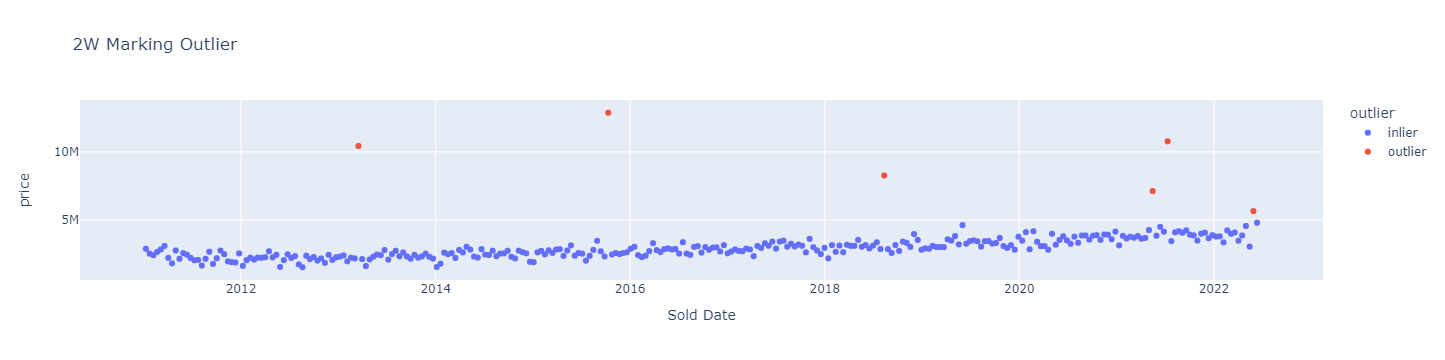

In [23]:
(
    dataf
    .assign(outlier = np.where(dataf["price"].le(dataf["price"].quantile(.98)), 'inlier','outlier'))
    #.set_index('solddate')
    .plot(kind="scatter",x="solddate", y="price", color="outlier", **plot_params)
    .update_layout(
        title=f"{FREQ} Marking Outlier",
    )
)

In [24]:
imputer = KNNImputer(n_neighbors=10, weights='distance', metric='nan_euclidean')

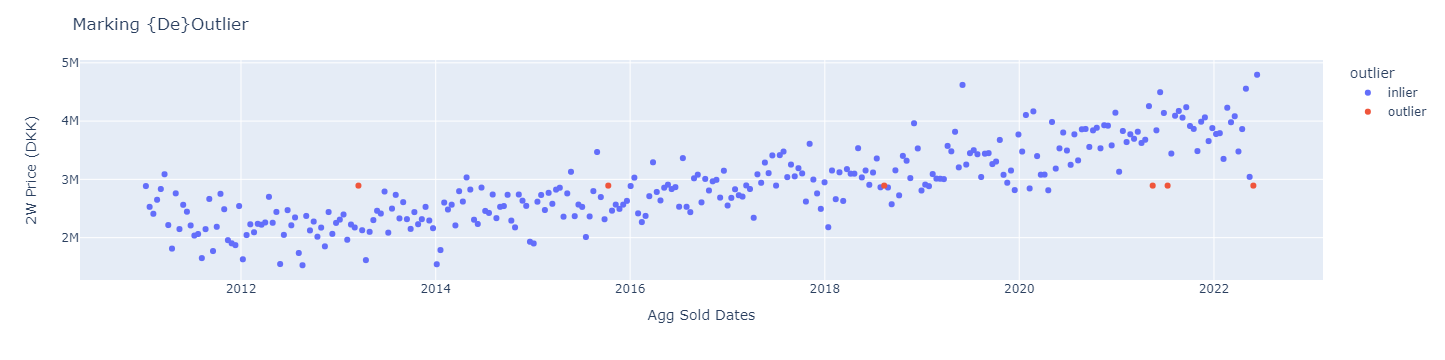

In [25]:
(
    dataf
    .assign(outlier = np.where(dataf["price"].le(dataf["price"].quantile(.98)), 'inlier','outlier'))
    #.set_index('solddate')
    .assign(price = np.where(dataf["price"].le(dataf["price"].quantile(.98)), dataf["price"], np.NaN))
    .assign(price = lambda d: imputer.fit_transform(d[['price']]))
    .plot(kind="scatter",x="solddate", y="price", color="outlier", backend="plotly")
    .update_layout(
        title="Marking {De}Outlier",
        yaxis_title=f" {FREQ} Price (DKK)",
        xaxis_title="Agg Sold Dates"
    )
)
    

In [26]:
train_dataf = (
    dataf
    .assign(outlier = lambda d: np.where(d["price"].le(d["price"].quantile(.98)), 'inlier','outlier'),
            price = lambda d: np.where(d["outlier"].eq('inlier'), d["price"], np.NaN))
    .assign(price = lambda d: imputer.fit_transform(d[['price']]))
)

In [ ]:
# We could also fillna with darts
# fill_missing_values(ts, fill="auto")  # using pandas.Dataframe.interpolate()

In [27]:
splitter = pd.Timestamp("20200901")

ts = TimeSeries.from_dataframe(train_dataf, 'solddate', 'price', freq=FREQ )
train, validate = ts.split_after(splitter)

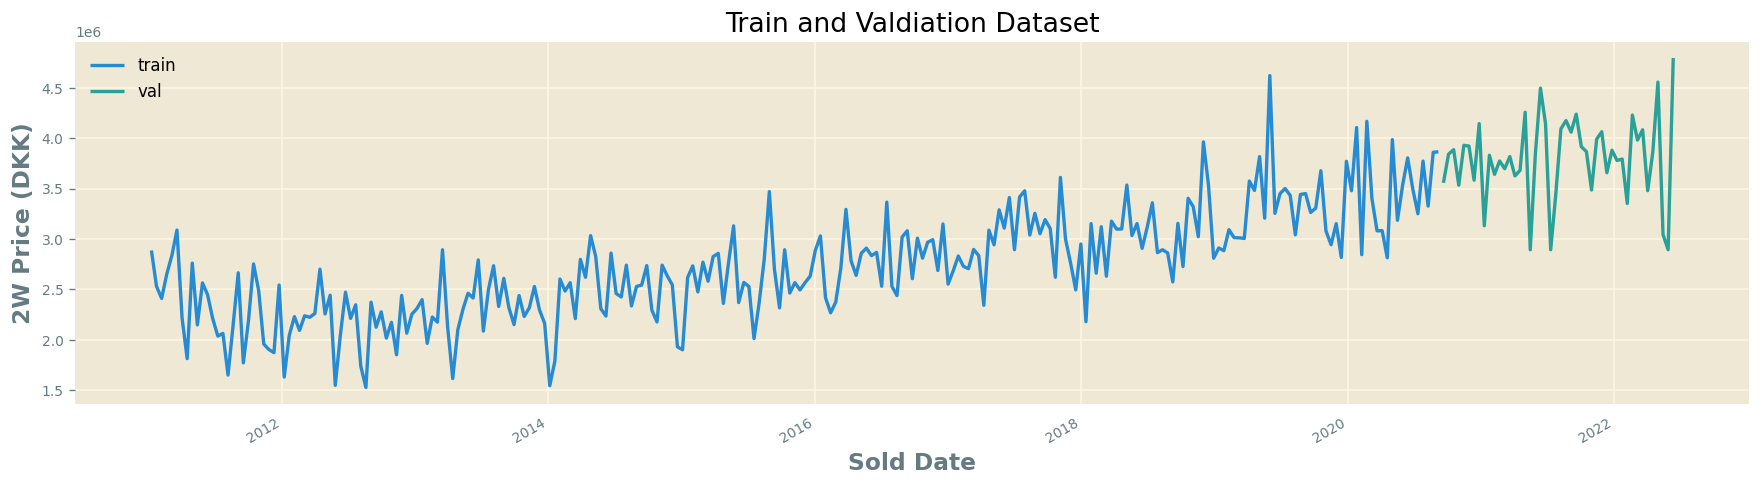

In [28]:
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize=(18, 4), dpi=120)
    train.plot(label="train")
    validate.plot(label="val")
    
    # Number of accent colors in the color scheme
    plt.title('Train and Valdiation Dataset')
    plt.xlabel('Sold Date', fontsize=14)
    plt.ylabel(f'{FREQ} Price (DKK)', fontsize=14)

In [29]:
validate.n_timesteps == len(val)

True

In [30]:
models = (FFT(nr_freqs_to_keep=14), AutoARIMA(), Prophet(), ExponentialSmoothing(), Theta())
model_store = {}

for model in models:
    print(f"Training {model}") 
    model.fit(train)
    prediction = model.predict(validate.n_timesteps)
    
    print(f"\tRMSE: {int(rmse(prediction, val))}")
    model_store[model.__class__.__name__] = model

Training FFT(nr_freqs_to_keep=14, trend=None)
	RMSE: 1601633
Training Auto-ARIMA
	RMSE: 501489
Training Prophet
	RMSE: 446420
Training ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
	RMSE: 437865
Training Theta(2)
	RMSE: 449523


In [31]:
model_store.keys()

dict_keys(['FFT', 'AutoARIMA', 'Prophet', 'ExponentialSmoothing', 'Theta'])

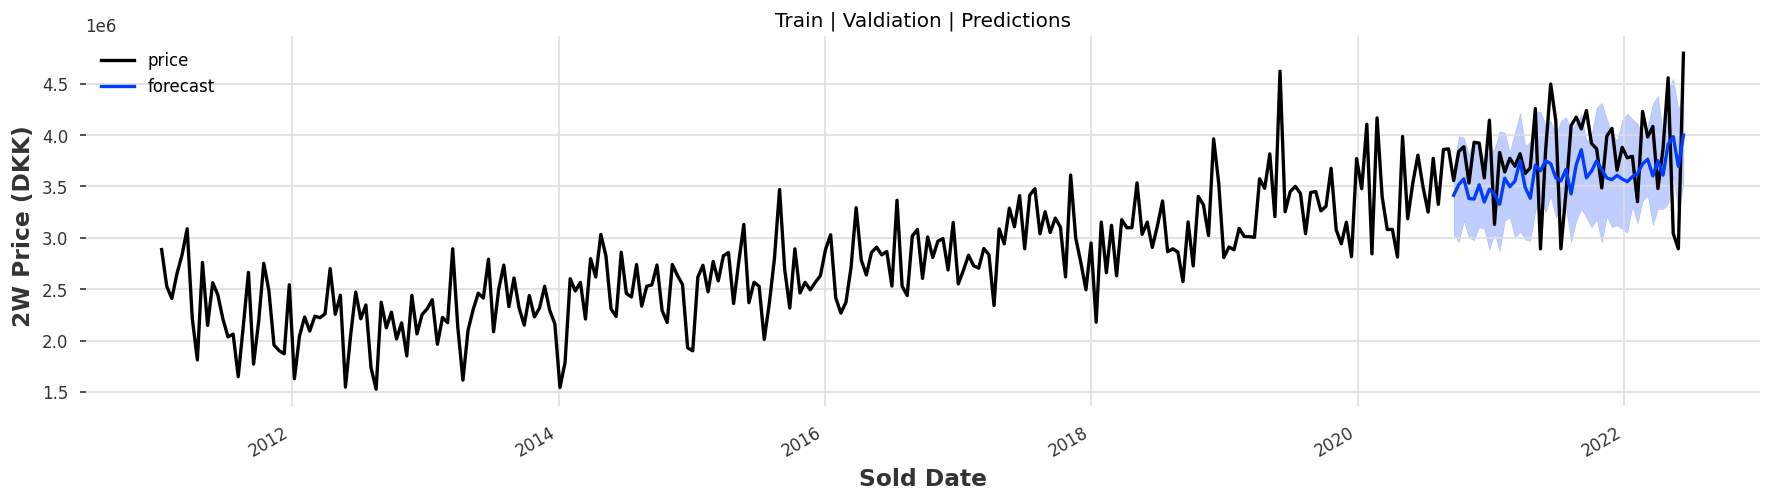

In [32]:
prediction = model_store["Prophet"].predict(val.n_timesteps, num_samples=30)

with plt.style.context('seaborn-notebook'):
    plt.figure(figsize=(18, 4), dpi=120)
    ts.plot()
    prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
    plt.legend()
    
    # Number of accent colors in the color scheme
    plt.title('Train | Valdiation | Predictions')
    plt.xlabel('Sold Date', fontsize=14)
    plt.ylabel(f'{FREQ} Price (DKK) ', fontsize=14)

In [48]:
prophet = model_store["Prophet"]

In [53]:
history = prophet.historical_forecasts(
    series= ts,
    past_covariates = ts.split_after(pd.Timestamp("20190901")),
    num_samples = 10,

)

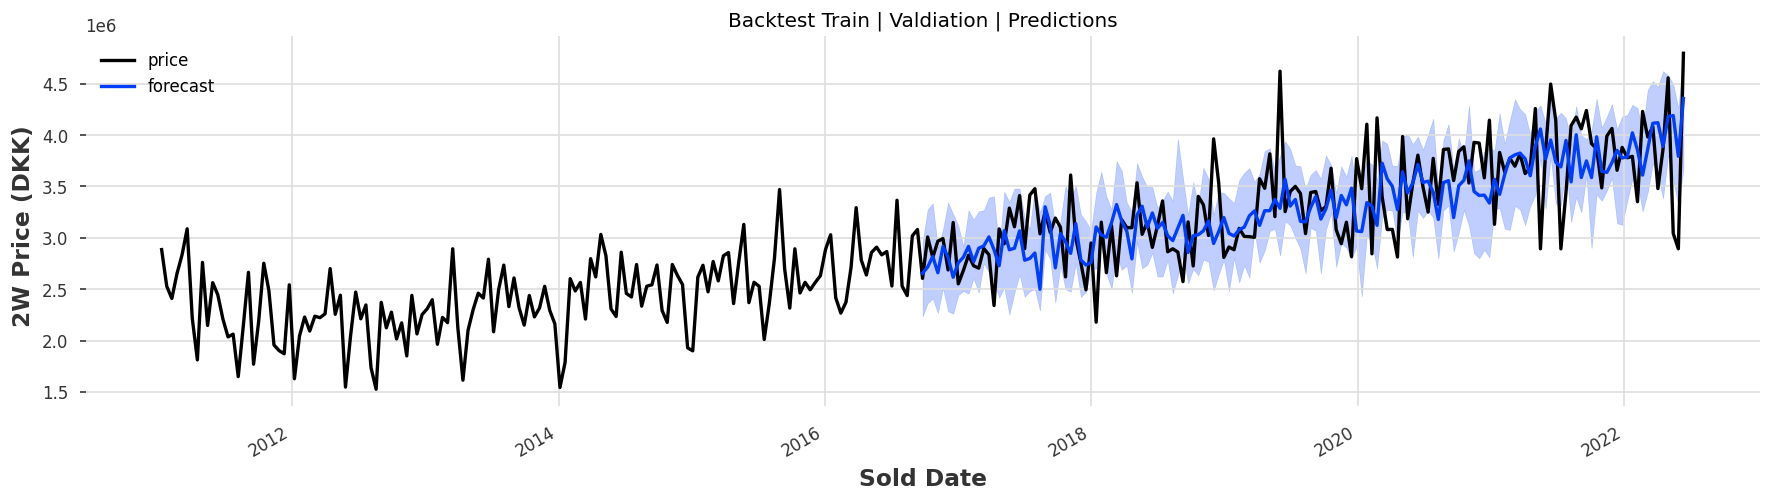

In [54]:
with plt.style.context('seaborn-notebook'):
    plt.figure(figsize=(18, 4), dpi=120)
    ts.plot()
    history.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
    plt.legend()
    
    # Number of accent colors in the color scheme
    plt.title('Train | Valdiation | Backtest Predictions')
    plt.xlabel('Sold Date', fontsize=14)
    plt.ylabel(f'{FREQ} Price (DKK) ', fontsize=14)

In [49]:
?

Signature:
prophet.historical_forecasts(
    series: darts.timeseries.TimeSeries,
    past_covariates: Optional[darts.timeseries.TimeSeries] = None,
    future_covariates: Optional[darts.timeseries.TimeSeries] = None,
    num_samples: int = 1,
    train_length: Optional[int] = None,
    start: Union[pandas._libs.tslibs.timestamps.Timestamp, float, int] = 0.5,
    forecast_horizon: int = 1,
    stride: int = 1,
    retrain: bool = True,
    overlap_end: bool = False,
    last_points_only: bool = True,
    verbose: bool = False,
) -> Union[darts.timeseries.TimeSeries, List[darts.timeseries.TimeSeries]]
Docstring:
Compute the historical forecasts that would have been obtained by this model on the `series`.

This method uses an expanding training window;
it repeatedly builds a training set from the beginning of `series`. It trains the
model on the training set, emits a forecast of length equal to forecast_horizon, and then moves
the end of the training set forward by `stride` time steps.



In [ ]:
with plt.style.context('seaborn-notebook'):
    plt.figure(figsize=(18, 4), dpi=120)
    ts.plot()
    prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
    plt.legend()
    
    # Number of accent colors in the color scheme
    plt.title('Train | Valdiation | Predictions')
    plt.xlabel('Sold Date', fontsize=14)
    plt.ylabel(f'{FREQ} Price (DKK) ', fontsize=14)